![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)

# Tutoriel pour récupérer et superposer plusieurs couches WMS

## Introduction

A _Web Map Service_ tels que [GeoMet du SMC](https://eccc-msc.github.io/open-data/msc-geomet/readme_en/) fournit diverses couches utiles pour visualiser différentes données géospatiales, telles que des tempêtes dans le cas de GeoMet du SMC. Chaque requête WMS GetMap valide répond avec une image de la couche demandée, mais aucune carte de base n'est présente. Ce document montre ainsi comment créer une carte statique en assemblant un nombre arbitraire de couches sur une carte de base, et la procédure pour l'exporter à l'aide de [OWSLib](https://geopython.github.io/OWSLib/).

## Définition des librairies dépendantes

OWSLib et PIL sont les deux bibliothèques utilisées et doivent être installées avant d'exécuter d'autres cellules de ce document.
OWSLib est une librairie qui permet de faire des requêtes WMS GetMap à un serveur WMS en Python tandis que PIL est une librairie qui permet de manipuler différents formats d'images.

In [51]:
# Importation des modules Python
import io
import warnings

# Les modules suivant doivent d'abbord être installées
from owslib.wms import WebMapService
from PIL import Image
import requests

## Déclaration des variables
Une requête [WMS GetMap](https://eccc-msc.github.io/open-data/msc-geomet/web-services_fr/#wms-getmap) nécessite plusieurs paramètres de la part de l'utilisateur. 

- **Nom de la couche**. Une liste des couches peut être trouvée à l'aide d'une requête WMS GetCapabilities (exemple: [WMS GetCapabilities de GeoMet-Météo](https://geo.weather.gc.ca/geomet?lang=en&service=WMS&version=1.3.0&request=GetCapabilities)) ou en utilisant des fonctions de OWSLib pour itérer sur la sortie cette dernière, comme démontré dans la [documentation d'OWSLib](https://geopython.github.io/OWSLib/usage.html#wms)  
(eg. CURRENT_CONDITIONS)
- **Bounding Box**, une liste de 4 éléments représentant les limites géographiques de la carte que nous voulons voir. Le format est ***min_x,min_y,max_x,max_y***, où X représente la longitude et Y la latitude. 
(eg. -108.546753, 35.081279, -42.493286, 57.212106)
- **La projection cartographique** (SRS) de la couche représenté par un code EPSG. 
(eg. 4326)
- **Taille de l'image** sous la forme de deux valeurs entières, soit la largeur (*width*) de l'image et de la hauteur (*height*) de l'image.
(eg. 1400, 600)
- **Opacité** de la couche également connue sous le nom de canal Alpha de l'image. Ce canal est utilisé pour s'assurer qu'aucun calque ne masque les calques empilés en dessous. Noter que l'opacité n'est pas un paramètre obligatoire dans une requête WMS GetMap, mais est recommandé pour l'atteinte du but de ce document. 
(eg. 0.8)

À titre d'exemple, il est possible de composer une carte en utilisant un mélange de couches sur une région spécifique en utilisant les variables ci-dessous.

In [52]:
list_of_geomet_layers = ['GDPS.ETA_TT',
                         'RADAR_RRAI']

# Les coordonnées doivent être des valeurs valides pour la couche WMS
# Elles doivent aussi être dans la projection du crs
min_x, min_y, max_x, max_y = [-108.546753, 35.081279, -42.493286, 57.212106]
crs = "EPSG:4326"

width = 1400
height = 600
format_ = "image/png"
alpha = 0.8

nrcan_basemap_url = "https://maps.geogratis.gc.ca/wms/CBMT?service=wms&version=1.3.0&request=GetMap&layers=CBMT&BBOX={},{},{},{}&CRS={}&WIDTH={}&HEIGHT={}&format={}"
nrcan_basemap_url = nrcan_basemap_url.format(min_y, min_x, max_y, max_x, crs, width, height, format_)

## Récupération des images

Tout d'abord, on récupère la carte de fond à l'aide de la requête WMS GetMap qui a été composée précédemment. Cette requête WMS a été faite avec le serveur WMS *Geogratis* de Ressources Naturelles Canada, un service qui permet de récupérer la carte de fond du Canada dans le cadre de ce tutoriel.

In [53]:
basemap = Image.open(requests.get(nrcan_basemap_url, stream=True).raw)
basemap = basemap.convert('RGBA')

La cellule suivante supprime les avertissements et les erreurs de la connexion initiale au serveur WMS émis par OWSLib dans le but de ne pas encombrer l'espace de travail.

In [54]:
warnings.filterwarnings('ignore', module='owslib', category=UserWarning)

Ici, la définition du serveur WMS (GeoMet-Météo), auquel les requêtes seront effectuées, est faite dans le but obtenir les couches de données géospatiales désirées.


In [55]:
wms = WebMapService('https://geo.weather.gc.ca/geomet?SERVICE=WMS' +
                    '&REQUEST=GetCapabilities',
                    version='1.3.0',
                    timeout=300)

Maintenant que la connexion à GeoMet-Météo est définie, il est possible de parcourir la liste des couches désirées et d'effectuer les requêtes WMS GetMap appropriées. Ensuite, ces requêtes sont converties sous format d'images Python à l'aide du constructeur Image de la librairie PIL.

In [56]:
list_of_geomet_images = []

for layer in list_of_geomet_layers: 
  temporary_response = wms.getmap(
      layers=[layer],
      srs=crs,
      bbox=(min_x, min_y, max_x, max_y),
      size=(width, height),
      format=format_,
      transparent=True)
  temporary_image = Image.open(io.BytesIO(temporary_response.read()))
  temporary_image = temporary_image.convert('RGBA')
  list_of_geomet_images.append(temporary_image)

## Composition de l'image finale

Maintenant qu'une liste d'images résultantes de requêtes WMS GetMap ainsi qu'un fond de carte sont disponibles, il ne reste qu'à superposer ces dernières pour obtenir le résultat visuel recherché.

In [57]:
def overlayImage(base, top):
  tmp_img_comp = Image.alpha_composite(base, top)
  tmp_img_comp.putalpha(tmp_img_comp.getchannel('A').point(lambda x: x*alpha))
  return tmp_img_comp

overlays_composite = overlayImage(list_of_geomet_images[0],list_of_geomet_images[1])

final_map = Image.alpha_composite(basemap, overlays_composite)

## Exportation de l'image finale

Avant d'exporter le tout, l'image finale peut être visualisée et validée.

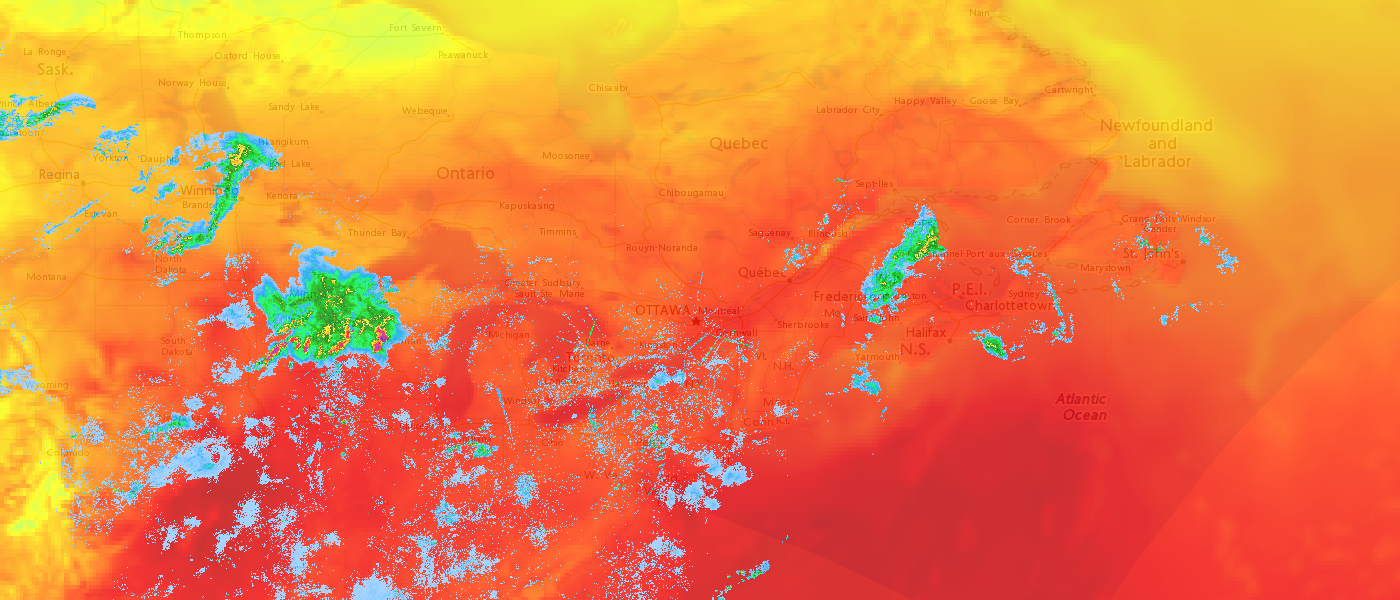

In [58]:
final_map

Lorsque le résultat est adéquat aux besoins, il est possible d'exporter pouvons exporter cette dernière sous un format d'image conventionnel (le PNG dans ce cas-ci).

In [59]:
final_map.save('map.png')

## Ajout de la dimension temporelle
Il est possible d'ajouter une dimension temporelle au script et de l'utiliser pour créer des images GIF à l'aide de la librairie OWSLib


In [60]:
from datetime import datetime, timedelta
import re 

def time_parameters(layer):
    start_time, end_time, interval = (wms[layer]
                                      .dimensions['time']['values'][0]
                                      .split('/')
                                      )
    iso_format = '%Y-%m-%dT%H:%M:%SZ'
    start_time = datetime.strptime(start_time, iso_format)
    end_time = datetime.strptime(end_time, iso_format)
    interval = int(re.sub(r'\D', '', interval))
    return start_time, end_time, interval


start_time, end_time, interval = time_parameters('RADAR_1KM_RRAI')

time_ = [start_time]
time_increment = start_time
while time_increment < end_time:
    time_increment = time_increment + timedelta(minutes=interval)
    time_.append(time_increment)

In [61]:
time_

[datetime.datetime(2021, 8, 24, 9, 50),
 datetime.datetime(2021, 8, 24, 10, 0),
 datetime.datetime(2021, 8, 24, 10, 10),
 datetime.datetime(2021, 8, 24, 10, 20),
 datetime.datetime(2021, 8, 24, 10, 30),
 datetime.datetime(2021, 8, 24, 10, 40),
 datetime.datetime(2021, 8, 24, 10, 50),
 datetime.datetime(2021, 8, 24, 11, 0),
 datetime.datetime(2021, 8, 24, 11, 10),
 datetime.datetime(2021, 8, 24, 11, 20),
 datetime.datetime(2021, 8, 24, 11, 30),
 datetime.datetime(2021, 8, 24, 11, 40),
 datetime.datetime(2021, 8, 24, 11, 50),
 datetime.datetime(2021, 8, 24, 12, 0),
 datetime.datetime(2021, 8, 24, 12, 10),
 datetime.datetime(2021, 8, 24, 12, 20),
 datetime.datetime(2021, 8, 24, 12, 30),
 datetime.datetime(2021, 8, 24, 12, 40),
 datetime.datetime(2021, 8, 24, 12, 50)]